In [27]:
from functions import *
from methods import *
import seaborn as sns
import matplotlib.pyplot as plt

#from methods_both import *
import mobilenetv2_DANN
import graphviz
from keras.utils.vis_utils import plot_model
import pickle as pkl
import pandas as pd
import numpy as np

from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import random

from keras.engine import Layer

from flip_gradient import *

In [34]:
def reverse_gradient(X, hp_lambda):
    '''Flips the sign of the incoming gradient during training.'''
    try:
        reverse_gradient.num_calls += 1
    except AttributeError:
        reverse_gradient.num_calls = 1

    grad_name = "GradientReversal%d" % reverse_gradient.num_calls

    @tf.RegisterGradient(grad_name)
    def _flip_gradients(op, grad):
        return [tf.negative(grad) * hp_lambda]

    g = get_session().graph
    with g.gradient_override_map({'Identity': grad_name}):
        y = tf.identity(X)

    return y

class GradientReversal(Layer):
    '''Flip the sign of gradient during training.'''
    def __init__(self, hp_lambda, **kwargs):
        super(GradientReversal, self).__init__(**kwargs)
        self.supports_masking = False
        self.hp_lambda = hp_lambda

    def build(self, input_shape):
        self.trainable_weights = []

    def call(self, x, mask=None):
        return reverse_gradient(x, self.hp_lambda)

    def get_output_shape_for(self, input_shape):
        return input_shape

    def get_config(self):
        config = {}
        base_config = super(GradientReversal, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [36]:
path = '/Users/irashokar/documents/NOvA/files/Feb_test/Dann/'
with open(path + 'history_DANN_2_feb_weights.pkl','rb') as f1:
    history = pkl.load(f1)


ValueError: Unknown layer: GradientReversal

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy gibuu and genie sgd')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['acc', 'val acc'], loc='lower left')
plt.ylim(0.4,0.75)
plt.show()

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss gibuu and genie sgd')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val loss'], loc='lower left')
plt.ylim(0.1,1.5)
plt.show()

In [7]:
with open(path+ 'both_probabilities_short_weights_DANN_2_feb_weights.pkl','rb') as f2:
    probabilities = pkl.load(f2)[0]
print(len(probabilities))
with open(path+ 'both_test_labels_list_short_weights_DANN_2_feb_weights.pkl','rb') as f3:
    test_labels = pkl.load(f3)
print(len(test_labels))
with open(path+ 'both_test_weights_list_short_weights_DANN_2_feb_weights.pkl','rb') as f4:
    gibuu_weights = pkl.load(f4)

14624
14629


In [8]:
predictions = []
for i in probabilities:
    max_index =np.where(i == np.max(i))[0][0]
    predictions.append(max_index)
    
test_vals = []
for i in test_labels:
    max_index =np.where(i == np.max(i))[0][0]
    test_vals.append(max_index)
    
#accuracy
acc = 0
for i in range(len(probabilities)):
    if test_vals[i]==predictions[i]:
        acc+=1
    else:
        pass
acc/=len(test_vals)

true_val = probabilities

print('Probabilities: \n')
print('Accuracy:{} \n'.format(acc))
for i in range(10):
    print(probabilities[i], '\n')
print('Predictions: \n')
print(predictions[:10], '\n')
print('Truth labels: \n')
print(test_vals[:10])

Probabilities: 

Accuracy:0.6150112789664365 

[0.39635986 0.07081976 0.5328204 ] 

[0.6311717  0.08710142 0.28172693] 

[0.20364136 0.0398848  0.75647384] 

[0.551142   0.10870314 0.34015495] 

[0.15551718 0.04127876 0.80320406] 

[0.2838005  0.06711635 0.64908314] 

[0.4988754  0.07896834 0.4221562 ] 

[0.6092079  0.14411943 0.24667259] 

[0.56365997 0.10245001 0.33389002] 

[0.31461155 0.06658765 0.61880076] 

Predictions: 

[2, 0, 2, 0, 2, 2, 0, 0, 0, 2] 

Truth labels: 

[0, 2, 0, 0, 1, 0, 0, 2, 0, 2]


Text(0, 0.5, 'Count')

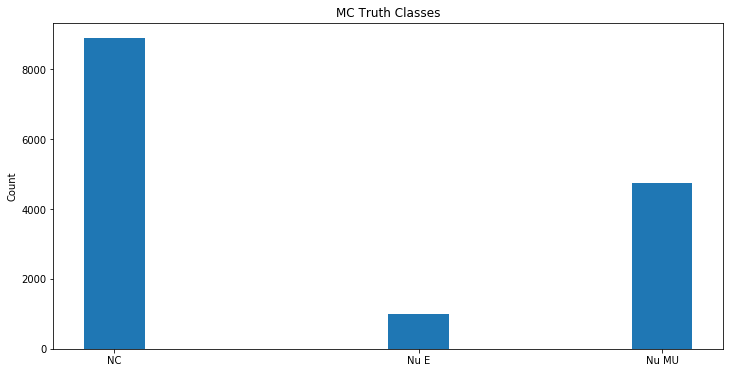

In [9]:
plt.figure(figsize=(12,6))
plt.hist(test_vals)
x = [0.1, 1.1, 1.9]
class_names = ['NC', 'Nu E', 'Nu MU']
plt.xticks(x, class_names)
plt.title('MC Truth Classes')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

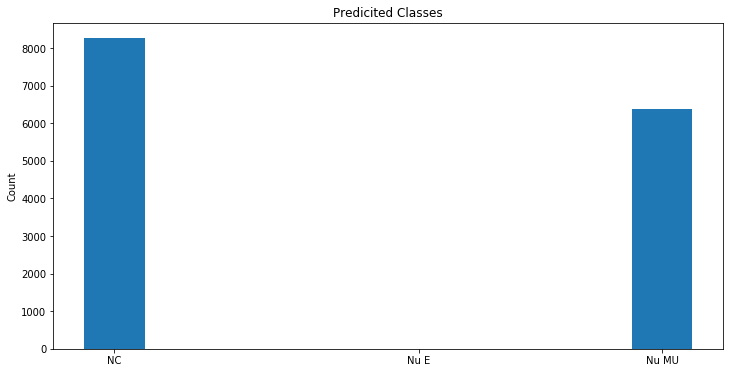

In [10]:
plt.figure(figsize=(12,6))
plt.hist(predictions)
x = [0.1, 1.1, 1.9]
class_names = ['NC', 'Nu E', 'Nu MU']
plt.xticks(x, class_names)
plt.title('Predicited Classes')
plt.ylabel('Count')

[(0, 1)]

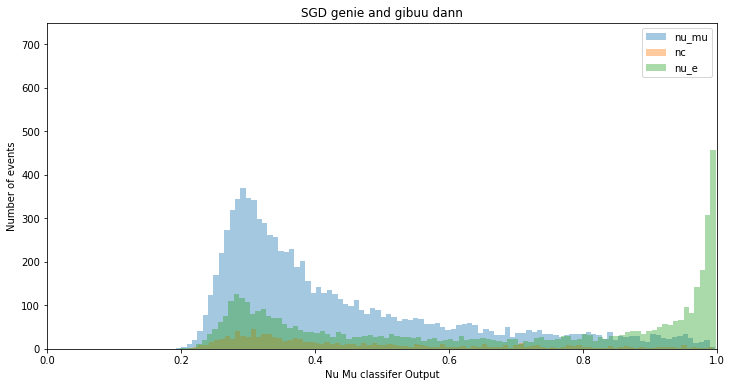

In [22]:
mu_e = []
nc = []
nu_mu = []
for i in range(len(probabilities)):
    if test_vals[i] ==0:
        nc.append(probabilities[i,2])
    elif test_vals[i] ==1:
        mu_e.append(probabilities[i,2])
    elif test_vals[i] ==2:
        nu_mu.append(probabilities[i,2])
        
plt.figure(figsize=(12,6))
g = sns.distplot(nc, bins = 100, kde=False)
g = sns.distplot(mu_e, bins = 100, kde=False)
g = sns.distplot(nu_mu, bins = 100, kde=False)
plt.legend(['nc', 'nu_e','nu_mu'], loc='upper right')
plt.legend(['nu_mu', 'nc', 'nu_e'], loc='upper right')
plt.xlabel('Nu Mu classifer Output')
plt.ylabel('Number of events')
plt.title('SGD genie and gibuu dann')
g.set(ylim=(0,750))
g.set(xlim=(0,1))

[(0, 1)]

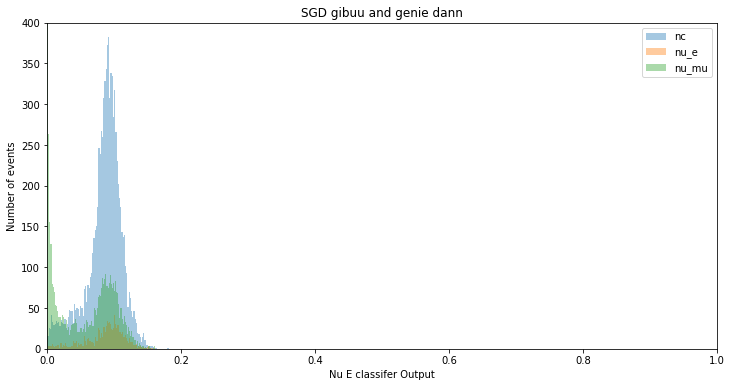

In [21]:
mu_e = []
nc = []
nu_mu = []
for i in range(len(probabilities)):
    if test_vals[i] ==0:
        nc.append(probabilities[i,1])
    elif test_vals[i] ==1:
        mu_e.append(probabilities[i,1])
    elif test_vals[i] ==2:
        nu_mu.append(probabilities[i,1])
        
plt.figure(figsize=(12,6))
g = sns.distplot(nc, bins = 100, kde=False)
g = sns.distplot(mu_e, bins = 100, kde=False)
g = sns.distplot(nu_mu, bins = 100, kde=False)
plt.legend(['nc', 'nu_e','nu_mu'], loc='upper right')
plt.xlabel('Nu E classifer Output')
plt.ylabel('Number of events')
plt.title('SGD gibuu and genie dann')
g.set(ylim=(0,400))
g.set(xlim=(0,1))

[(0, 1)]

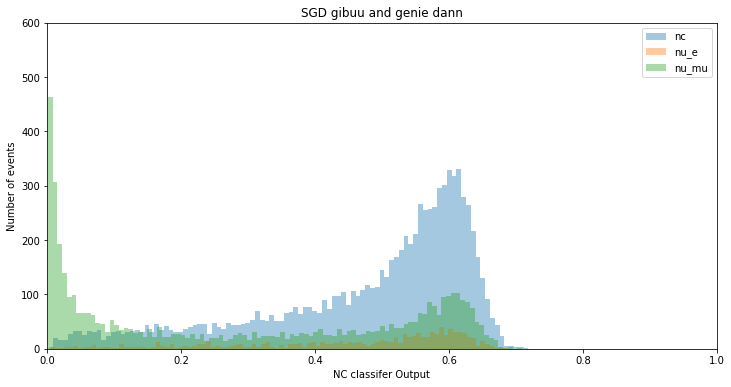

In [20]:
mu_e = []
nc = []
nu_mu = []
for i in range(len(probabilities)):
    if test_vals[i] ==0:
        nc.append(probabilities[i,0])
    elif test_vals[i] ==1:
        mu_e.append(probabilities[i,0])
    elif test_vals[i] ==2:
        nu_mu.append(probabilities[i,0])
        
plt.figure(figsize=(12,6))
g = sns.distplot(nc, bins = 100, kde=False)
g = sns.distplot(mu_e, bins = 100, kde=False)
g = sns.distplot(nu_mu, bins = 100, kde=False)
plt.legend(['nc', 'nu_e','nu_mu'], loc='upper right')
plt.xlabel('NC classifer Output')
plt.ylabel('Number of events')
plt.title('SGD gibuu and genie dann')
g.set(ylim=(0,600))
g.set(xlim=(0,1))

In [16]:
purity_list = []
efficiency_list = []
p_x_e_list = []

gibuu_weights=[float(i) for i in gibuu_weights]
 
for j in np.arange(0, 0.99, 0.01):
    nu_mu_above = []
    nu_mu_below = []
    nc_above = []
    nc_below = []
    nu_e_above = []
    nu_e_below = []
    for i in range(len(probabilities)):
        if test_vals[i] ==2:
            if probabilities[i,2]>=j:
                nu_mu_above.append(probabilities[i,2]*gibuu_weights[i])
            elif probabilities[i,2]<=j:
                nu_mu_below.append(probabilities[i,2]*gibuu_weights[i])
                
        elif test_vals[i] ==0:         
            if probabilities[i,2]>=j:
                nc_above.append(probabilities[i,2]*gibuu_weights[i])
            elif probabilities[i,2]<=j:
                nc_below.append(probabilities[i,2]*gibuu_weights[i])
                
        elif test_vals[i] ==1:        
            if probabilities[i,2]>=j:
                nu_e_above.append(probabilities[i,2]*gibuu_weights[i])
            elif probabilities[i,2]<=j:
                nu_e_below.append(probabilities[i,2]*gibuu_weights[i])
                
        
                
    purity = len(nu_mu_above)/(len(nc_above)+len(nu_mu_above)+len(nu_e_above))
    purity_list.append(purity)

    efficiency = len(nu_mu_above)/(len(nu_mu_above)+len(nu_mu_below))
    efficiency_list.append(efficiency)

    p_x_e_list.append(purity*efficiency)
    


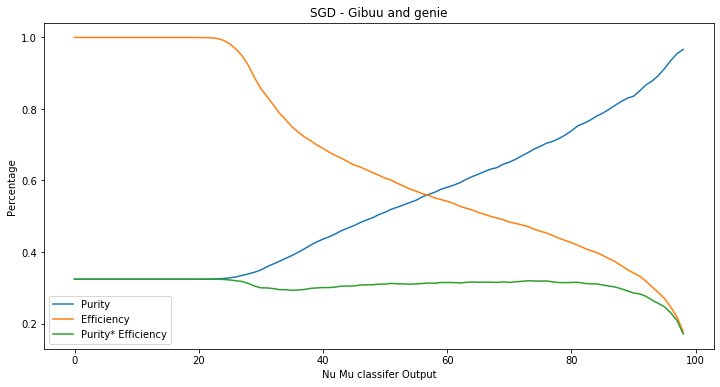

In [17]:
plt.figure(figsize=(12,6))
plt.plot(purity_list)
plt.plot(efficiency_list)
plt.plot(p_x_e_list)
plt.xlabel('Nu Mu classifer Output')
plt.ylabel('Percentage')
plt.title('SGD - Gibuu and genie')
plt.legend(['Purity', 'Efficiency', 'Purity* Efficiency'], loc='lower left')

In [ ]:
purity_list = []
efficiency_list = []
p_x_e_list = []
 
for j in np.arange(0, 0.25, 0.01):
    nu_mu_above = []
    nu_mu_below = []
    nc_above = []
    nc_below = []
    nu_e_above = []
    nu_e_below = []
    for i in range(len(probabilities)):
        if test_vals[i] ==2:
            if probabilities[i,1]>=j:
                nu_mu_above.append(probabilities[i,1]*gibuu_weights[i])
            elif probabilities[i,1]<=j:
                nu_mu_below.append(probabilities[i,1]*gibuu_weights[i])
            
                
        elif test_vals[i] ==0:         
            if probabilities[i,1]>=j:
                nc_above.append(probabilities[i,1]*gibuu_weights[i])
            elif probabilities[i,1]<=j:
                nc_below.append(probabilities[i,1]*gibuu_weights[i])
            
                
        elif test_vals[i] ==1:        
            if probabilities[i,1]>=j:
                nu_e_above.append(probabilities[i,1]*gibuu_weights[i])
            elif probabilities[i,1]<=j:
                nu_e_below.append(probabilities[i,1]*gibuu_weights[i])
                
        
                
    purity = len(nu_e_above)/(len(nc_above)+len(nu_mu_above)+len(nu_e_above))
    purity_list.append(purity)

    efficiency = len(nu_e_above)/(len(nu_e_above)+len(nu_e_below))
    efficiency_list.append(efficiency)

    p_x_e_list.append(purity*efficiency)
    

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(purity_list)
plt.plot(efficiency_list)
plt.plot(p_x_e_list)
plt.xlabel('Nu E classifer Output')
plt.ylabel('Percentage')
plt.title('SGD - Gibuu and genie ')
plt.legend(['Purity', 'Efficiency', 'Purity* Efficiency'], loc='lower left')